In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import geopandas as gpd
import rioxarray as rxr
import rasterio
from rasterio.plot import show, adjust_band
from matplotlib import cm
import matplotlib
from scipy import stats
import datetime
from constants import *

os.chdir(home_dir)
plt.style.use(home_dir+'stylefile.mplstyle')

tmp = []
for i in range(len(fire_sn)):
    tmp.append(datetime.datetime.strptime(fire_sn['Ig_Date'][i], '%Y-%m-%d'))
fire_sn['dt'] = tmp

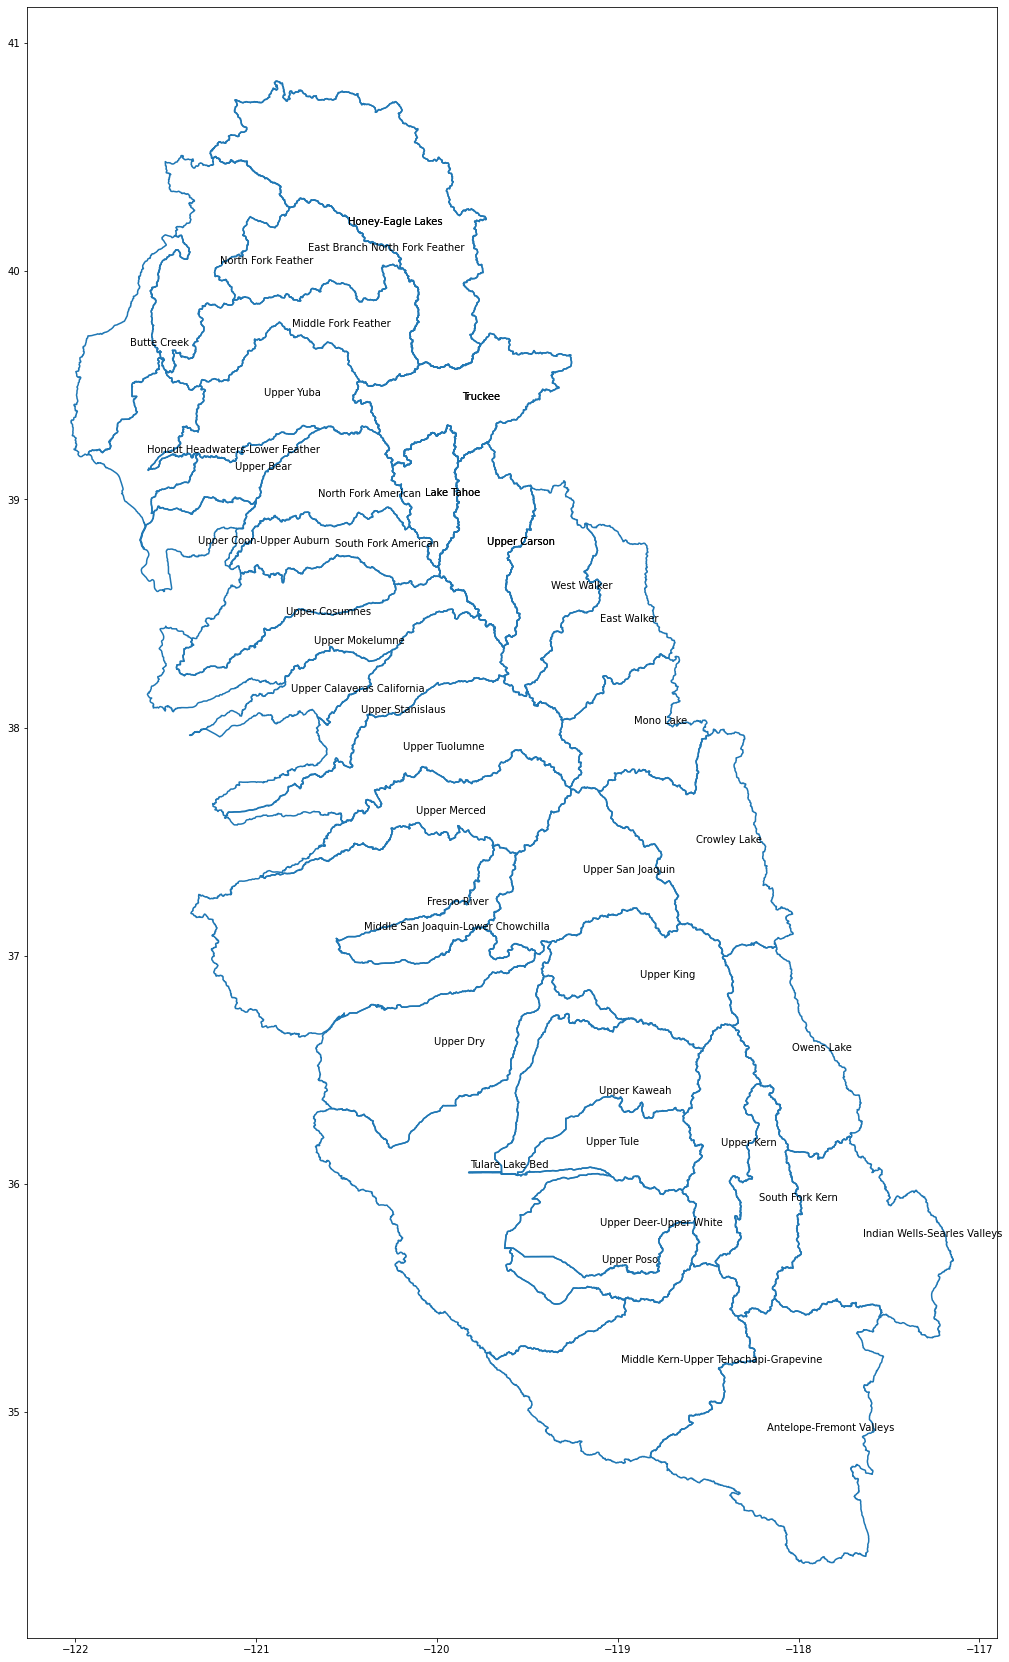

In [60]:
f,ax=plt.subplots(figsize=(30,30))
sn_watersheds.boundary.plot(ax=ax)
for i in sn_watersheds.index:
    tmp = sn_watersheds[(sn_watersheds.index==i)]
    x = (tmp.bounds.minx[i]+tmp.bounds.maxx[i])/2
    y = (tmp.bounds.miny[i]+tmp.bounds.maxy[i])/2
    name = tmp.name[i]
    ax.text(x,y,name)

In [61]:
# san joaquin watershed
targets = ['Upper San Joaquin','Upper Tuolumne']
names = sn_watersheds.name
tmp =[names[i] in targets for i in range(len(names))]
idx = np.arange(44)[tmp]
tmp1 = sn_watersheds[sn_watersheds.index == 1]
tmp2 = sn_watersheds[sn_watersheds.index == 2]
tmp3 = tmp1.append(tmp2)
tmp3

# san joaquin watershed
targets = ['Upper San Joaquin','Upper Tuolumne','Upper King','Upper Merced','Upper Kaweah','Upper Kern','Upper Tule']
sj = sn_watersheds[sn_watersheds.name == targets[0]]
for t in range(1,len(targets)):
    tmp = sn_watersheds[(sn_watersheds.name==targets[t])]
    sj = sj.append(tmp)
sj.name
sj.to_file('upper_watersheds.shp')


In [376]:
targets_sw = ['Upper San Joaquin','Upper Tuolumne','Upper King','Upper Merced','Upper Kaweah','Upper Kern','Upper Tule','South Fork Kern']
targets_se = ['West Walker','East Walker','Mono Lake','Crowley Lake','Owens Lake','Indian Wells-Searles Valley']
targets_ne = ['East Branch North Fork Feather','Middle Fork Feather','Truckee','Lake Tahoe','Upper Carson']
targets_nw = ['Upper Yuba','North Fork American','South Fork American','Upper Cosumnes','Upper Mokelumne','Upper Stanislaus']
targets_all = [targets_sw,targets_se,targets_ne,targets_nw]

0
1
2
3


'\nfor i in sn_watersheds.index:\n    tmp = sn_watersheds[(sn_watersheds.index==i)]\n    x = (tmp.bounds.minx[i]+tmp.bounds.maxx[i])/2\n    y = (tmp.bounds.miny[i]+tmp.bounds.maxy[i])/2\n    name = tmp.name[i]\n    ax.text(x,y,name)\n'

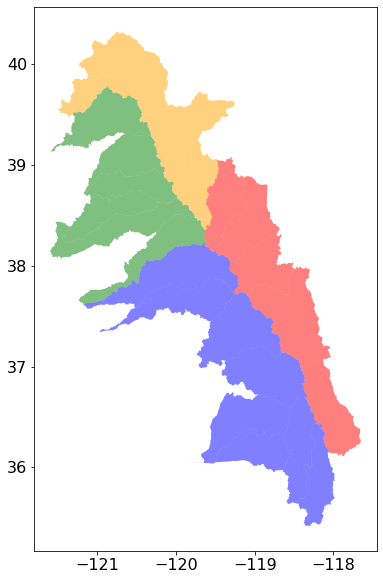

In [420]:
f,ax=plt.subplots(figsize=(10,10))
# sn_watersheds.boundary.plot(ax=ax)
colors = ['blue','red','orange','green']

for i,targets in enumerate(targets_all):
    sheds = sn_watersheds[sn_watersheds.name == targets[0]]
    for t in range(1,len(targets)):
        tmp = sn_watersheds[(sn_watersheds.name==targets[t])]
        try:
            tmp = tmp[tmp.index==tmp.index[0]]
        except:
            continue
        #print(len(tmp))
        #x = (tmp.bounds.minx[i]+tmp.bounds.maxx[i])/2
        # y = (tmp.bounds.miny[i]+tmp.bounds.maxy[i])/2
        #name = tmp.name[i]
        #ax.text(x,y,name)
        sheds = sheds.append(tmp)
    sheds.plot(ax=ax, color = colors[i],alpha = 0.5)
    #print(sheds)
    print(i)

'''
for i in sn_watersheds.index:
    tmp = sn_watersheds[(sn_watersheds.index==i)]
    x = (tmp.bounds.minx[i]+tmp.bounds.maxx[i])/2
    y = (tmp.bounds.miny[i]+tmp.bounds.maxy[i])/2
    name = tmp.name[i]
    ax.text(x,y,name)
'''

In [400]:
len(sn_watersheds[(sn_watersheds.name==targets[t])])

1

In [414]:
tmp[tmp.index==30]

,tnmid,metasource,sourcedata,sourceorig,sourcefeat,loaddate,gnis_id,areaacres,areasqkm,states,...,NA_L2CODE,NA_L2NAME,NA_L1CODE,NA_L1NAME,STATE_NAME,EPA_REGION,L3_KEY,L2_KEY,L1_KEY,geometry
30,{AF398494-9758-4C2C-9D1B-920E60EC9EC5},None,None,None,None,2012-06-11,0.0,873423.0,3534.696349,CA,...,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,California,9,5 Sierra Nevada,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,"POLYGON ((-120.24343 40.02986, -120.24238 40.0..."


In [370]:
def watershed_data_burned(targets,filename):
    sj = sn_watersheds[sn_watersheds.name == targets[0]]

    for t in range(1,len(targets)):
        tmp = sn_watersheds[(sn_watersheds.name==targets[t])]
        sj = sj.append(tmp)
    
    import datetime

    fire_time = 10 #yrs
    swe_sj = {}
    swe_sj_burned = {}
    swe_sj_unburned = {}
    sai_sj = {}
    sai_sj_burned = {}
    sai_sj_unburned = {}

    gpp_sj = {}
    gpp_tot_sj ={}
    gpp_sj_burned = {}
    gpp_sj_unburned = {}
    gpp_tot_sj_burned ={}
    gpp_tot_sj_unburned ={}
    ndvi_sj = {}
    ndvi_sj_burned = {}
    ndvi_sj_unburned = {}
    for yr in range(2000,2016):
        timestop =datetime.datetime(yr,10,1)
        timestart = datetime.datetime(yr-fire_time,10,1)
        prev_fires = fire_sn[fire_sn['dt']<timestop]
        prev_fires = prev_fires[prev_fires['dt']>timestart]

        swe = rxr.open_rasterio(data_dir + 'max_swe'+str(yr)+'.tif')
        swe = swe.rio.write_crs(sj.crs)
        clipped = swe.rio.clip(sj.geometry,all_touched=True,from_disk=False)
        clipped.rio.set_nodata(np.nan)
        swe_sj[yr]=clipped
        out_fire = clipped.rio.clip(prev_fires.geometry, from_disk=False, invert = True)
        swe_sj_unburned[yr]=out_fire
        in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
        swe_sj_burned[yr]=in_fire

        #SAI
        sai = rxr.open_rasterio(pe_data_dir + 'sai_'+str(yr)+'.tif')
        clipped = sai.rio.clip(sj.geometry,all_touched=True)
        clipped.rio.set_nodata(np.nan)
        clipped[np.where(clipped==np.inf)]=np.nan
        clipped[np.where(clipped>3000)]=np.nan
        clipped[np.where(clipped<0)]=np.nan
        sai_sj[yr]=clipped
        out_fire= clipped.rio.clip(prev_fires.geometry, from_disk=False, invert = True)
        sai_sj_unburned[yr] = out_fire
        in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk=False)
        sai_sj_burned[yr]=in_fire
        # GPP
        id = yr-2000
        gpp_means = []
        gpp_means_burned = []
        gpp_means_unburned = []
        gpp_all = {}
        gpp_all_burned = {}
        gpp_all_unburned = {}
        for mo in range(1,13):
            gppmean = 0
            gppmean_burned = 0
            try:
                tmp = rxr.open_rasterio(data_dir + 'modis_clip_'+str(id)+'_'+str(mo)+'.tif')
                clipped = tmp.rio.clip(sj.geometry,all_touched=True)
                clipped[np.where(clipped>5000)] = np.nan
                gppmean = np.nanmean(clipped)
                gpp_all[mo]=clipped
                out_fire= clipped.rio.clip(prev_fires.geometry, from_disk=False, invert = True)
                in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk=False)
                gpp_all_burned[mo]=in_fire
                gpp_all_unburned[mo]=out_fire
                gppmean_burned = np.nanmean(in_fire)
                gppmean_unburned = np.nanmean(out_fire)
            except:
                continue
            gpp_means.append(gppmean)
            gpp_means_burned.append(gppmean_burned)
            gpp_means_unburned.append(gppmean_unburned)
        max_mo = np.nanargmax(gpp_means)+1
        gpp = rxr.open_rasterio(data_dir+'modis_clip_'+str(id)+'_'+str(max_mo)+'.tif')
        clipped = gpp.rio.clip(sj.geometry,all_touched=True)
        clipped.rio.set_nodata(np.nan)
        clipped[np.where(clipped>5000)] = np.nan
        gpp_sj[yr]=clipped
        out_fire= clipped.rio.clip(prev_fires.geometry, from_disk=False, invert = True)
        in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk=False)
        gpp_sj_burned[yr]=in_fire
        gpp_sj_unburned[yr]=out_fire
        gpp_sum = np.zeros((clipped.shape[1:]))
        for k in gpp_all.keys():
            gpp_sum += gpp_all[k][0,:,:]
        gpp_tot_sj[yr]=gpp_sum
        gpp_sum_burned = np.zeros((in_fire.shape[1:]))
        gpp_sum_unburned = np.zeros((out_fire.shape[1:]))
        for k in gpp_all_burned.keys():
            gpp_sum_burned += gpp_all_burned[k][0,:,:]
        gpp_tot_sj_burned[yr]=gpp_sum_burned
        for k in gpp_all_unburned.keys():
            gpp_sum_unburned += gpp_all_unburned[k][0,:,:]
        gpp_tot_sj_unburned[yr]=gpp_sum_unburned


        #NDVI
        ndvi = rxr.open_rasterio(data_dir + 'pe_snow_fires_data/max-ndvi/max-ndvi-' + str(yr)+'.tif')
        #pe = pe.rio.write_crs(sj.crs)
        clipped = ndvi.rio.clip(sj.geometry,all_touched=True)
        clipped.rio.set_nodata(np.nan)
        out_fire= clipped.rio.clip(prev_fires.geometry, from_disk=False, invert = True)
        in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk=False, invert = False)
        ndvi_sj[yr]=clipped
        ndvi_sj_burned[yr]=in_fire
        ndvi_sj_unburned[yr] = out_fire
    
    gpp_by_month = np.zeros((clipped.shape[1:]))
    gpp_by_month_burned = np.zeros((clipped.shape[1:]))
    gpp_by_month_unburned = np.zeros((clipped.shape[1:]))

    for yr in range(2000,2016):
        for mo in range(1,13):
                gppmean = 0
                gppmean_burned = 0
                try:
                    tmp = rxr.open_rasterio(data_dir + 'modis_clip_'+str(yr-2000)+'_'+str(mo)+'.tif')
                    clipped = tmp.rio.clip(sj.geometry,all_touched=True)
                    clipped[np.where(clipped>5000)] = np.nan
                    gppmean = np.nanmean(clipped)
                    gpp_by_month[yr-2000, mo-1] = gppmean
                    in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
                    gpp_all_burned[mo]=in_fire
                    gppmean_burned = np.nanmean(in_fire)
                    gpp_by_month_burned[yr-2000, mo-1] = gppmean_burned
                    out_fire = clipped.rio.clip(prev_fires.geometry, all_touched= False, from_disk = True,invert=True)
                    gppmean_unburned = np.nanmean(out_fire)
                    gpp_by_month_unburned[yr-2000, mo-1] = gppmean_unburned
                except:
                    continue
    
    keys = range(2000,2015)
    swe_means = [np.nanmean(swe_sj[k]) for k in keys]
    sai_means = [np.nanmean(sai_sj[k]) for k in keys]
    gpp_means = [np.nanmean(gpp_sj[k+1]) for k in keys]
    ndvi_means = [np.nanmean(ndvi_sj[k+1]) for k in keys]
    gpp_tot_means = [np.nanmean(gpp_tot_sj[k+1]) for k in keys]
    swe_means_burned = [np.nanmean(swe_sj_burned[k]) for k in keys]
    sai_means_burned = [np.nanmean(sai_sj_burned[k]) for k in keys]
    gpp_means_burned = [np.nanmean(gpp_sj_burned[k+1]) for k in keys]
    ndvi_means_burned = [np.nanmean(ndvi_sj_burned[k+1]) for k in keys]
    gpp_tot_means_burned = [np.nanmean(gpp_tot_sj_burned[k+1]) for k in keys]
    swe_means_unburned = [np.nanmean(swe_sj_unburned[k]) for k in keys]
    sai_means_unburned = [np.nanmean(sai_sj_unburned[k]) for k in keys]
    gpp_means_unburned = [np.nanmean(gpp_sj_unburned[k+1]) for k in keys]
    ndvi_means_unburned = [np.nanmean(ndvi_sj_unburned[k+1]) for k in keys]
    gpp_tot_means_unburned = [np.nanmean(gpp_tot_sj_unburned[k+1]) for k in keys]

    to_save = {'targets':targets,
                'swe_means': swe_means,
                'sai_means':sai_means,
                'gpp_means':gpp_means,
                'ndvi_means':ndvi_means,
                'gpp_tot_means':gpp_tot_means,
                'swe_means_burned': swe_means_burned,
                'sai_means_burned':sai_means_burned,
                'gpp_means_burned':gpp_means_burned,
                'ndvi_means_burned':ndvi_means_burned,
                'gpp_tot_means_burned':gpp_tot_means_burned,
                'swe_means_unburned': swe_means_unburned,
                'sai_means_unburned':sai_means_unburned,
                'gpp_means_unburned':gpp_means_unburned,
                'ndvi_means_unburned':ndvi_means_unburned,
                'gpp_tot_means_unburned':gpp_tot_means_unburned
                }
    
    with open(pe_data_dir + filename + '.pkl', 'wb') as file:
        pickle.dump(to_save, file)

    return targets

def plot_linear_four(xvar,yvar):
    f,ax=plt.subplots(2,2,figsize=(15,10))
    axs = ax.flatten()
    for k,region in enumerate(['northwest','northeast','southwest','southeast']):
        with open(pe_data_dir + region + '.pkl', 'rb') as file:
            data = pickle.load(file)

        x_b = normalize(data[xvar+'_means_burned'])
        y_b = normalize(data[yvar+'_means_burned'])
        x_u = normalize(data[xvar+'_means_unburned'])
        y_u = normalize(data[yvar+'_means_unburned'])

        n = 1  # degree of polynomial
        
        p_b, C_p_b = np.polyfit(x_b, y_b, n, cov=True)  # C_p is estimated covariance matrix
        t_b = np.linspace(min(x_b), max(x_b), 500)
        TT_b = np.vstack([t_b**(n-i) for i in range(n+1)]).T
        yi_b = np.dot(TT_b, p_b)  # matrix multiplication calculates the polynomial values
        C_yi_b = np.dot(TT_b, np.dot(C_p_b, TT_b.T)) # C_y = TT*C_z*TT.T
        sig_yi_b = np.sqrt(np.diag(C_yi_b))  # Standard deviations are sqrt of diagonal

        p_u, C_p_u = np.polyfit(x_u, y_u, n, cov=True)  # C_p is estimated covariance matrix
        t_u = np.linspace(min(x_u), max(x_u), 500)
        TT_u = np.vstack([t_u**(n-i) for i in range(n+1)]).T
        yi_u = np.dot(TT_u, p_u)  # matrix multiplication calculates the polynomial values
        C_yi_u = np.dot(TT_u, np.dot(C_p_u, TT_u.T)) # C_y = TT*C_z*TT.T
        sig_yi_u = np.sqrt(np.diag(C_yi_u))  # Standard deviations are sqrt of diagonal

        
        axs[k].plot(x_b,y_b,'o',color='darkgoldenrod',label='burned')
        axs[k].fill_between(t_b, yi_b+sig_yi_b, yi_b-sig_yi_b, alpha=.25,color='darkorange')
        axs[k].plot(t_b, yi_b,'-',color='red')


        axs[k].plot(x_u,y_u,'o',color='seagreen',label='unburned')
        axs[k].fill_between(t_u, yi_u+sig_yi_u, yi_u-sig_yi_u, alpha=.25,color='seagreen')
        axs[k].plot(t_u, yi_u,'-',color='seagreen')
        slope_b, intercept_b, r_value_b, p_value_b, std_err_b = stats.linregress(x_b, y_b)
        slope_u, intercept_u, r_value_u, p_value_u, std_err_u = stats.linregress(x_u, y_u)

        if(k>1): axs[k].set_xlabel(xvar)
        if(k%2==0): axs[k].set_ylabel(yvar)
        axs[k].set_title(region)
    #ax.legend()
    plt.show()



In [349]:
'''
watershed_data_burned(targets=targets_sw,filename = 'southwest')
watershed_data_burned(targets=targets_se,filename = 'southeast')
watershed_data_burned(targets=targets_ne,filename = 'northeast')
watershed_data_burned(targets=targets_nw,filename = 'northwest')
'''

C:\Users\Marianne\AppData\Local\Temp/ipykernel_20940/1949094883.py:149: RuntimeWarning: Mean of empty slice
  sai_means_burned = [np.nanmean(sai_sj_burned[k]) for k in keys]


['East Branch North Fork Feather',
 'Middle Fork Feather',
 'Truckee',
 'Lake Tahoe',
 'Upper Carson']

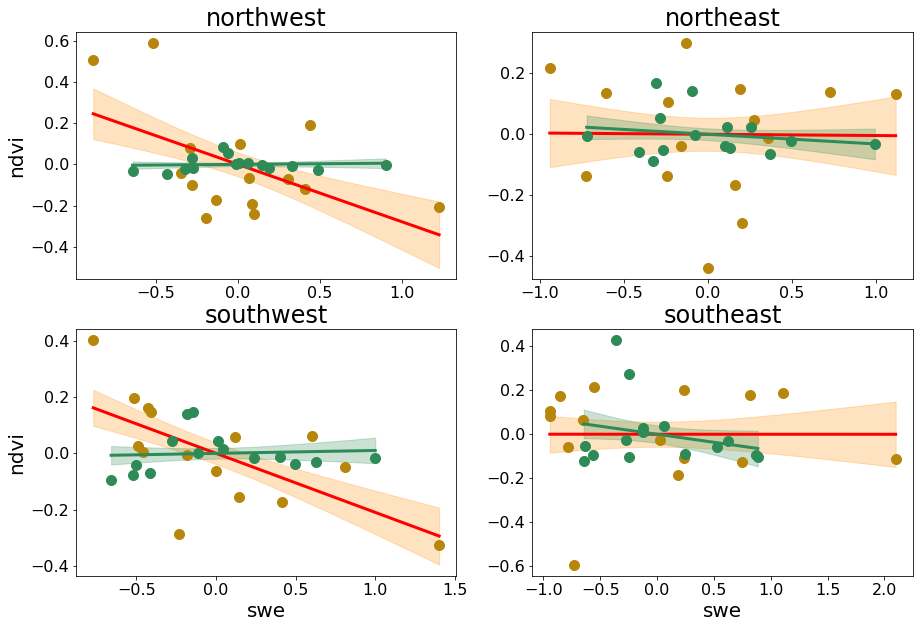

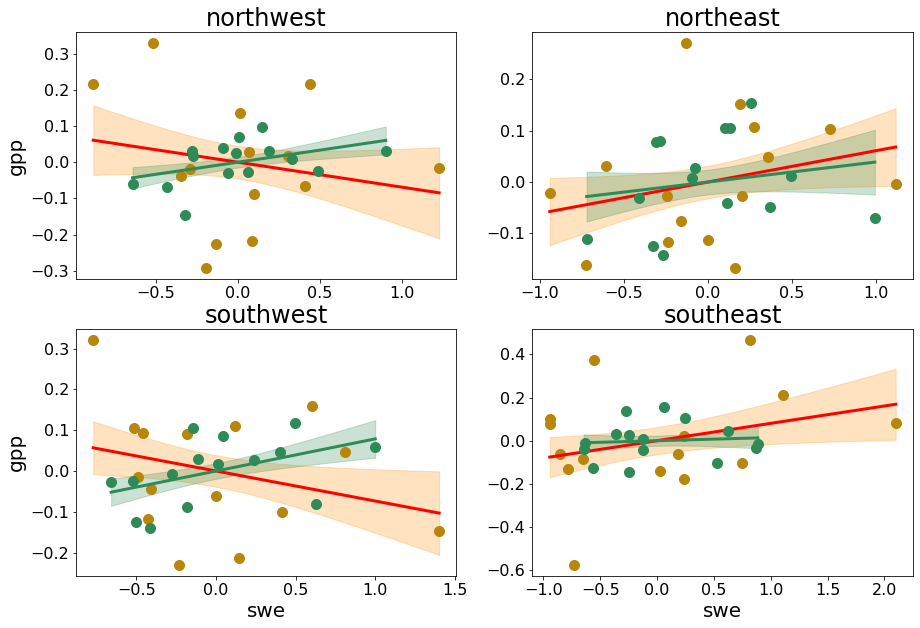

In [422]:
plot_linear_four(xvar = 'swe',yvar = 'ndvi')

plot_linear_four(xvar = 'swe',yvar = 'gpp')


#plot_linear(region = 'southeast',xvar = 'swe',yvar = 'gpp_tot')
#plot_linear(region = 'northeast',xvar = 'swe',yvar = 'gpp_tot')
#plot_linear(region = 'southwest',xvar = 'swe',yvar = 'gpp_tot')

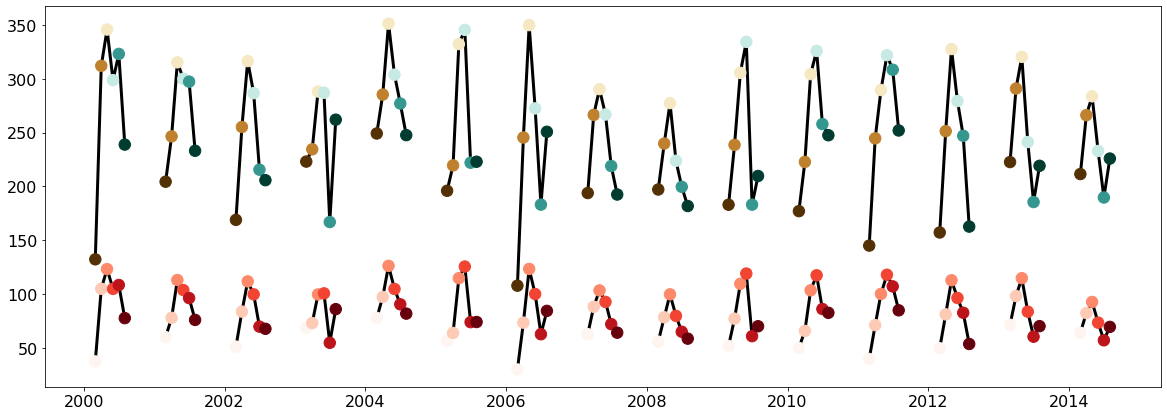

In [301]:
f,ax=plt.subplots(figsize=(20,7))
for yr in range(2000,2015):
    months = range(3,9)
    midx = [m-1 for m in months]
    data= gpp_by_month_unburned[yr-2000,midx]
    dates = [datetime.datetime(yr,m,1) for m in months]
    ax.plot(dates,data,'k-')
    ax.scatter(dates,data,c=range(6), cmap='BrBG',s=130, zorder=2.5)

for yr in range(2000,2015):
    months = range(3,9)
    midx = [m-1 for m in months]
    data= gpp_by_month_burned[yr-2000,midx]
    dates = [datetime.datetime(yr,m,1) for m in months]
    ax.plot(dates,data,'k-')
    ax.scatter(dates,data,c=range(6), cmap='Reds',s=130, zorder=2.5)


months = range(3,9)
texts = ['March','April','May','June','July','August']
midx = [m-1 for m in months]
n=350
data= [n,n,n,n,n,n]
yr = 2008
dates = [datetime.datetime(yr+m,m,1) for m in months]
ax.plot(midx,data,'k-')
ax.scatter(midx,data,c=range(6), cmap='BrBG',s=130, zorder=2.5)

for i in range(len(midx)):
    ax.text(midx[i]-0.45,data[i]-0.0025,texts[i],size=12)

plt.show()


-0.2935137256361064 0.5089805076787988 0.002822426299266138


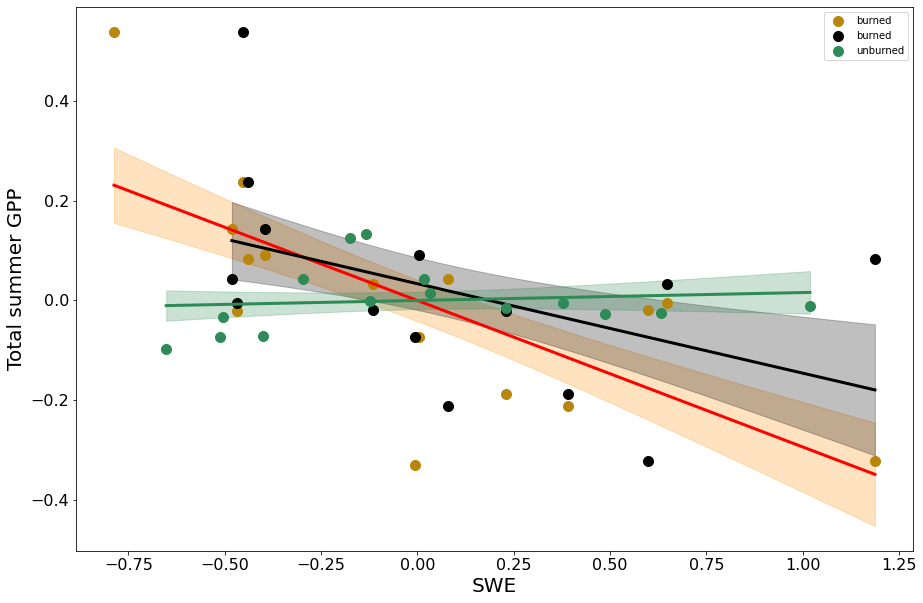

In [280]:
f,ax=plt.subplots(figsize=(15,10))
x = normalize(swe_means_burned)
y = normalize(ndvi_means_burned)
y2 = [y[i+1] for i in range(len(y)-1)]
idx=np.nanargmax(y)
x2 = x[0:-1]
#x = np.delete(x,idx)
#y = np.delete(y,idx)
#x = swe_means_burned
#y = gpp_means_burned
ax.plot(x,y,'o',color='darkgoldenrod',label='burned')

ax.plot(x2,y2,'o',color='black',label='burned')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
#ax.plot(x,p(x),"r--")

n = 1  # degree of polynomial
p, C_p = np.polyfit(x, y, n, cov=True)  # C_p is estimated covariance matrix

# Do the interpolation for plotting:
t = np.linspace(min(x), max(x), 500)
# Matrix with rows 1, t, t**2, ...:
TT = np.vstack([t**(n-i) for i in range(n+1)]).T
yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

ax.fill_between(t, yi+sig_yi, yi-sig_yi, alpha=.25,color='darkorange')
ax.plot(t, yi,'-',color='red')

z = np.polyfit(x2, y2, 1)
p = np.poly1d(z)
#ax.plot(x,p(x),"r--")

n = 1  # degree of polynomial
p, C_p = np.polyfit(x2, y2, n, cov=True)  # C_p is estimated covariance matrix

# Do the interpolation for plotting:
t = np.linspace(min(x2), max(x2), 500)
# Matrix with rows 1, t, t**2, ...:
TT = np.vstack([t**(n-i) for i in range(n+1)]).T
yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

ax.fill_between(t, yi+sig_yi, yi-sig_yi, alpha=.25,color='black')
ax.plot(t, yi,'-',color='black')
#ax.axis('tight')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(slope, r_value**2,p_value)

x = normalize(swe_means_unburned)
y = normalize(ndvi_means_unburned)
ax.plot(x,y,'o',color='seagreen',label='unburned')
n = 1  # degree of polynomial
p, C_p = np.polyfit(x, y, n, cov=True)  # C_p is estimated covariance matrix

# Do the interpolation for plotting:
t = np.linspace(min(x), max(x), 500)
TT = np.vstack([t**(n-i) for i in range(n+1)]).T
yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

ax.fill_between(t, yi+sig_yi, yi-sig_yi, alpha=.25,color='seagreen')
ax.plot(t, yi,'-',color='seagreen')
#ax.axis('tight')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)


#z = np.polyfit(x, y, 1)
#p = np.poly1d(z)
#ax.plot(x,p(x),":",color='seagreen')
ax.set_xlabel('SWE')
ax.set_ylabel('Total summer GPP')
ax.legend()
plt.show()

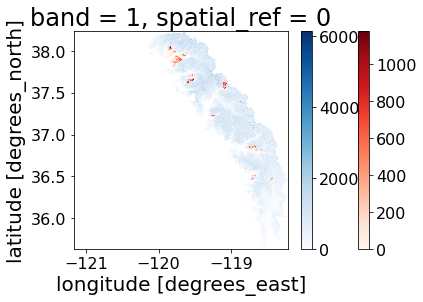

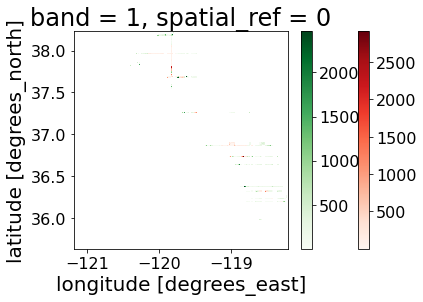

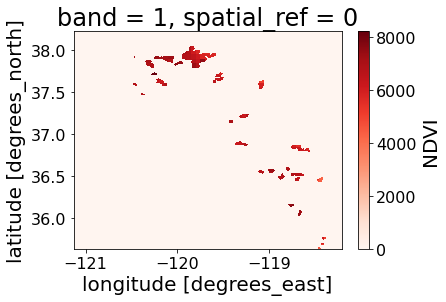

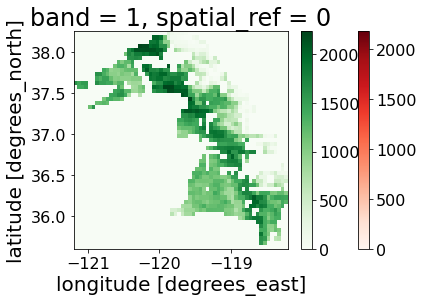

In [ ]:
k=2000
f,ax=plt.subplots()
swe_sj_burned[k].plot(ax=ax,cmap='Reds')
swe_sj_unburned[k].plot(ax=ax,cmap='Blues')
plt.show()
k=2015
f,ax=plt.subplots()
sai_sj_burned[k].plot(ax=ax,cmap='Reds')
sai_sj_unburned[k].plot(ax=ax,cmap='Greens')
plt.show()
k=2000
f,ax=plt.subplots()
ndvi_sj_burned[k].plot(ax=ax,cmap='Reds')
#ndvi_sj_unburned[k].plot(ax=ax,cmap='Greens')
plt.show()
k=2000
f,ax=plt.subplots()
gpp_sj_burned[k].plot(ax=ax,cmap='Reds')
gpp_sj_unburned[k].plot(ax=ax,cmap='Greens')
plt.show()


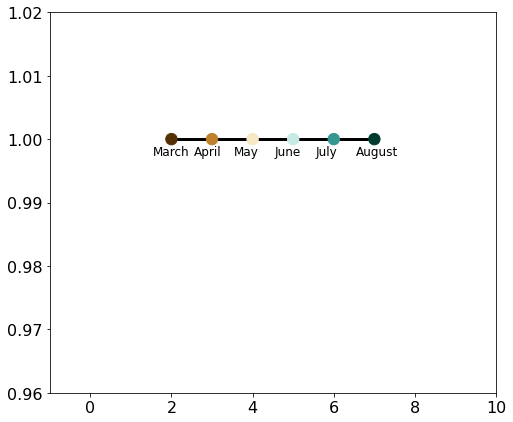